In [25]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# Hack para encontrar a pasta 'src' (sobe um nível)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Importar o modelo
from src.battery_model import BatteryModel

print("✅ Ambiente configurado. Modelos carregados!")

✅ Ambiente configurado. Modelos carregados!


# Análise Exploratória: Dinâmica da Bateria Li-Ion
Este notebook investiga duas características fundamentais que tornam a estimativa de carga (SoC) difícil em baterias de Lítio:
1. **Não-linearidade da OCV:** A tensão não varia linearmente com a carga.
2. **Histerese/Relaxamento:** A bateria tem "memória" curta devido à capacitância de polarização.

✅ Gráfico final (2-5V) salvo em: c:\Users\Pichau\Desktop\BMS-SoC-Estimator\images\ocv_curve.png


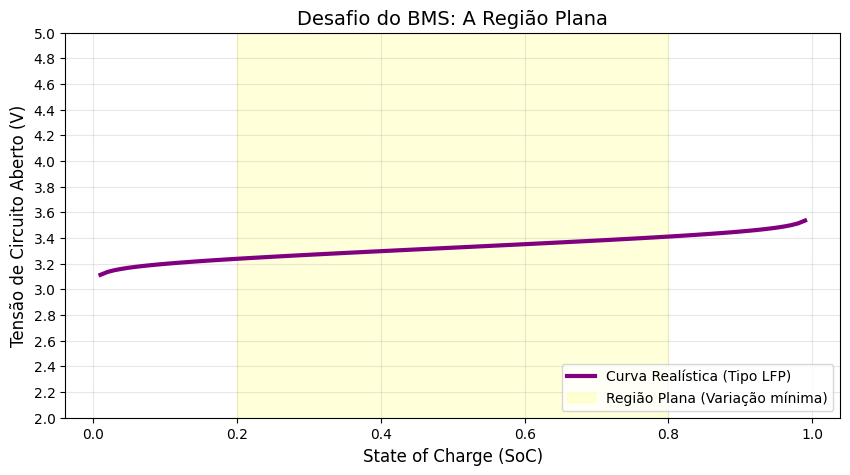

In [26]:
# Célula 3 [Code]
# Instanciar bateria
bat = BatteryModel()

# Gerar pontos de 1% a 99%
soc_values = np.linspace(0.01, 0.99, 100)

# Modelo LFP (Muito Plano)
ocv_real = 3.25 + (0.15 * soc_values) + 0.03 * np.log(soc_values / (1 - soc_values))

# Plotagem
plt.figure(figsize=(10, 5))
plt.plot(soc_values, ocv_real, linewidth=3, color='purple', label='Curva Realística (Tipo LFP)')

plt.title("Desafio do BMS: A Região Plana", fontsize=14)
plt.xlabel("State of Charge (SoC)", fontsize=12)
plt.ylabel("Tensão de Circuito Aberto (V)", fontsize=12)
plt.grid(True, alpha=0.3)

# --- MUDANÇAS APLICADAS ---
# 1. Escala Y de 2V a 5V (Meio termo ideal)
plt.ylim(2, 5)
# 2. Graduação Y de 0.2 em 0.2
plt.yticks(np.arange(2, 5.2, 0.2))

# Destacar a região crítica
plt.axvspan(0.2, 0.8, color='yellow', alpha=0.15, label='Região Plana (Variação mínima)')
plt.legend(loc='lower right')

# Salvar
import os
save_path = os.path.join(project_root, 'images', 'ocv_curve.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✅ Gráfico final (2-5V) salvo em: {save_path}")

plt.show()

### Análise
Observe a região amarela (20% a 80% SoC). A tensão muda muito pouco (a curva é quase reta).
Isso significa que um erro pequeno de leitura do voltímetro (ex: 0.01V) pode resultar em um erro gigante na estimativa de carga (10-15%). Por isso precisamos do **Filtro de Kalman** para fundir essa informação com a contagem de corrente.

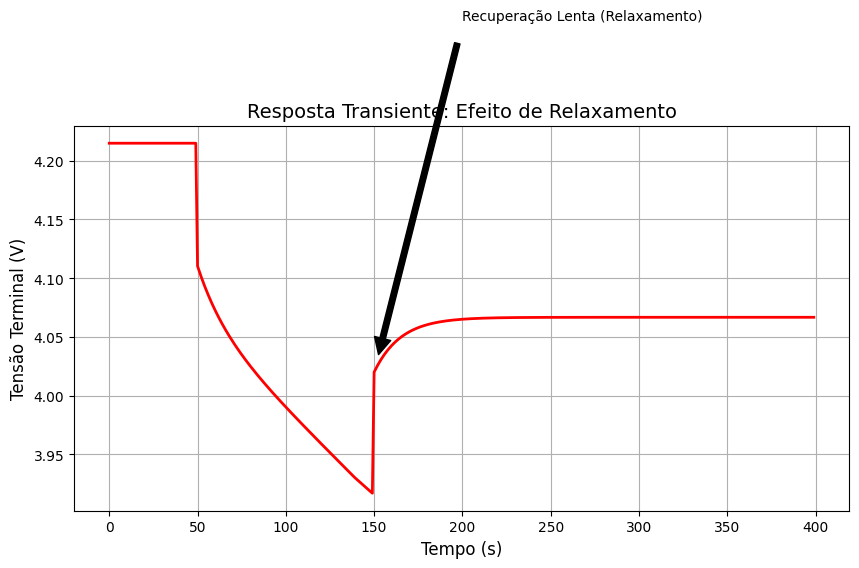

In [27]:
# Configuração do Tempo
dt = 1.0
time = np.arange(0, 400, dt)

# Criar um perfil de corrente: 0A -> 10A (Pulso) -> 0A
current = np.zeros_like(time)
current[50:150] = 10.0 # Pulso de descarga de 10A entre 50s e 150s

# Simular
v_out = []
bat = BatteryModel() # Bateria nova para este teste

for i, t in enumerate(time):
    v = bat.update(current[i], dt)
    v_out.append(v)

# Plotar
plt.figure(figsize=(10, 5))
plt.plot(time, v_out, color='red', linewidth=2)
plt.title("Resposta Transiente: Efeito de Relaxamento", fontsize=14)
plt.xlabel("Tempo (s)", fontsize=12)
plt.ylabel("Tensão Terminal (V)", fontsize=12)
plt.grid(True)

# Adicionar anotação explicativa
plt.annotate('Recuperação Lenta (Relaxamento)', 
             xy=(150, v_out[150]), 
             xytext=(200, v_out[150]+0.3),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()